In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Grab and process the raw data.
imdb_raw = pd.read_csv('imdb_labelled.txt', delimiter= '\t', header=None)
imdb_raw.columns = ['text', 'positive y/n']

amazon_raw = pd.read_csv('amazon_cells_labelled.txt', delimiter= '\t', header=None)
amazon_raw.columns = ['text', 'positive y/n']

yelp_raw = pd.read_csv('yelp_labelled.txt', delimiter= '\t', header=None)
yelp_raw.columns = ['text', 'positive y/n']

# joining the dataframes together
#alltext_raw = pd.concat([yelp_raw, amazon_raw, imdb_raw])
alltext_raw = amazon_raw


In [3]:
pro_keywords = ['great', 'super', 'excellent', 'sturdy', 'satisfied', 'best', 'good purchase', 'happy', 'good', 'nice', 'love', 'nice', 'comfortable', 'tremendous', 'forever', 'awesome', 'fast', 'decent', 'comfortable', 'flawless', 'helpful', 'wise', 'low price', 'easier', 'well finished', 'very well', 'promptly','amazed','well','easy','highly','again','good quality','high quality','smooth','pleasant','ly recommend', 'i like', 'y like']

for key in pro_keywords:
    alltext_raw[str(key)] = alltext_raw.text.str.contains(
        str(key),
        case=False
    )


In [4]:
con_keywords = ['not happy', 'waste of', 'beware', 'disappoint', 'bad', 'worst', 'flimsy', 'junk', 'avoid', 'poor', 't buy', 't recommend', 'return', 'lacking', 'unhappy', 'rip off', 'a problem', 'the problem', 'sucks', 'dead', 'break','mistake','broke','warning','dying','died','difficult','not good','uncomfortable','ugly','refund','unfortunate','defective','crap','cumbersome','hate','worthless','t work','complain','horrible','useless', 't like']

for key in con_keywords:
    alltext_raw[str(key)] = alltext_raw.text.str.contains(
        str(key),
        case=False
    )

Feature Engineering notes:

Primary source of features has been going through the dataframe and looking for particularly significant words and word sets, searching the entire dataframe for how many instances of those words appear, and then selecting the ones that have >3 instances where they accurately belong to a positive or negative review.  (Note that I only began sifting for frequency halfway through building the lists, so some of the earlier features appear only once in the entire database.)

Tested removing the con_keywords from the test, but that resulted in lower accuracy, so it does help the model learn, albeit not as much as the pro_keywords set.

Attempted to build an "'x' AND 'y'" feature, to better test for negative reviews, but unable to make it function.  Will continue to work on this in next challenge.

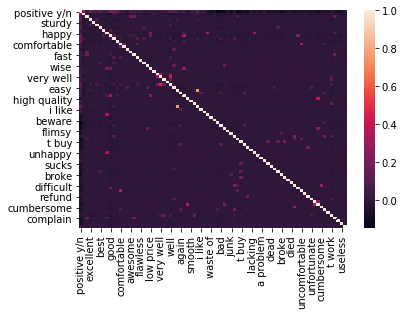

In [5]:
sns.heatmap(alltext_raw.corr())

# Heatmap shows few correlations, and only 1 significant one (likely a double such as "like" and "don't like," though I tried to weed those out).

Using alltext_raw = yelp_raw instead of amazon_raw produced... remarkably good results, compared to my expectations.  Even with many of the features not appearing in the new dataframe, it still had enough textual similarities to the amazon set that it produced 71% accuracy.


In [6]:
data = alltext_raw[
    pro_keywords 
    + 
    con_keywords
                  ]
target = alltext_raw['positive y/n']

In [7]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 201


Accuracy of ~20%.  Not terrible, though it could be better.  Further analysis (below) using the material from 2.3, shows that there's a distinct issue of false positives, likely due to the more amorphous nature of negative responses.  Another problem it runs into is that many of the features I've put in are specific to a handful (or even just 1) of the reviews, which means that samples without those specific features lose some of their accuracy.

In [8]:
from sklearn.metrics import confusion_matrix
confusion_matrix(target, y_pred)

array([[471,  29],
       [172, 328]])

In [9]:
from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

With 20% Holdout: 0.77
Testing on Sample: 0.799


In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(bnb, data, target, cv=10)

array([0.84, 0.75, 0.83, 0.76, 0.79, 0.75, 0.76, 0.76, 0.8 , 0.74])